In [1]:
# Useful libraries
import numpy as np
import pandas as pd
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import sympy as sym

We give here a method to solve numerically the differential equation $\frac{1}{r}\frac{d}{dr}(r\frac{d\psi}{dr})-\frac{m^{2}}{r^{2}}\psi-\frac{dj_{\phi}/dr}{\frac{B_{\theta}}{\mu_{0}}(1-\frac{nq}{m})}\psi=0$ (ref : J. Wesson, Tokamaks, Eq.(6.8.7), p.320)

**<span style="color:red;">1</span>** $\textbf{The idea}$ is to convert this second order ODE to one system of first order ODE, i.e in the form $\dot{\vec{x}}(t)=\vec{f}(\vec{x}(t))$ This do this, we write 
- $\psi \equiv y_{1}$, $ \quad$ $'\equiv \frac{d}{dr}$ 
- $y'_{1}=y_{2}$ <span style="color:green;">(1)</span>
- $y'_{2}=\left(\frac{m^{2}}{r^{2}}+\frac{dj_{\phi}/dr}{\frac{B_{\theta}}{\mu_{0}}(1-\frac{nq}{m})}\right)y_{1}-\frac{y_{2}}{r}$ <span style="color:green;">(2)</span>

Where these equations form a first order ODE system with $\dot{\vec{x}}(t)=(y_{1}',y_{2}')$ and $\vec{f}(\vec{x}(t))=(y_{2}, \left(\frac{m^{2}}{r^{2}}+\frac{dj_{\phi}/dr}{\frac{B_{\theta}}{\mu_{0}}(1-\frac{nq}{m})}\right)y_{1}-\frac{y_{2}}{r})$

$q = \frac{rB_{\phi}}{RB_{\theta}}\equiv \frac{r}{B_{\theta}}T$ is known. $r$ is the discretization, and the ratio between $R$ and $B_{\phi}$ is set to a constant (due to our cylindrical approx). Thus we can deduce the poloidal component $B_{\theta}=\frac{rB_{\phi}}{qR}\equiv \frac{r}{q}T$ 

In addition, the $q$ profile used here is of the form $q(r) = q_{0}\left[1+\left(\frac{r}{r_{0}}\right)^{2}\right]$, with $(q_{0}, r_{0}) = (1.2, 0.81)$

**<span style="color:red;">2</span>** Now, we are going to use the python function $\textbf{scipy.integrate.solve\_bvp}$

$\textbf{NOTE}$ :
- We observe a singularity for $q=\frac{m}{n}$, so we need to solve it from its left & right
- In order to use $\textbf{solve\_bvp}$, the procedure is inspired of examples in https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#scipy.integrate.solve_bvp
- We use fixed boundary, i.e the perturbation is 0 at the boundaries : $\psi(0) = \psi(L) = 0$

$\textbf{INPUTS}$

In [2]:
# Global parameters
T = 1 # ratio between the toroidal component and the major radius (see the def of q)
m = 2 # number of poloidal Fourier modes
n = 1 # number of toroidal Fourier modes

# q parameters
q_0 = 1.2
r_0 = 0.8164965809277261
r_mesh = np.linspace(0.01, 1, 2000)

$T=\frac{B_{\phi}}{R}$

In [3]:
def q_sym(q_string, numerical=False):
    """  Parameters
          - q_string : string expression of q profile
          - numerical : if False, return SymPy expr, if True return associated numerical expr
         Returns
          q_ : q profile as SymPy or numerical expr
    """  
    r, f_ = sym.symbols('r, f')
    q_ = sym.sympify(q_string)

    if(numerical==True):
        return sym.lambdify(r, q_) # q as numerical expression
    else:
        return q_ # q as SymPy expression

In [4]:
# test
q_profile_sym = q_sym('1.2*(1+(r/0.81)**2)', numerical=False)
q_profile_num = q_sym('1.2*(1+(r/0.81)**2)', numerical=True)

Text(0, 0.5, '$q$')

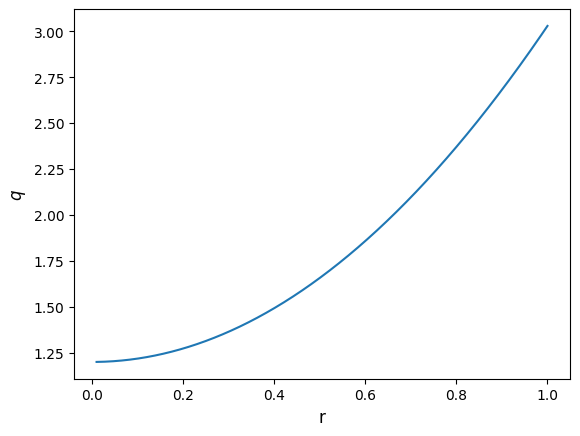

In [5]:
plt.plot(r_mesh, q_profile_num(r_mesh), label='$q$ profile')
plt.xlabel('r', fontsize=12)
plt.ylabel('$q$', fontsize=12)

Computation of $\textbf{B}_{\theta}$

In [6]:
def B_theta_sym(T_, q_, numerical=False):
    """  Parameters
          - T_ : ratio between the toroidal component and the major radius
          - q_ : q profile as SymPy (symbolic) expr
          - numerical : if False, return SymPy expr, if True return associated numerical expr
         Returns
          B_theta_ : poloidal magnetic profile as SymPy or numerical expr
    """  
    r, f_ = sym.symbols('r, f')
    B_theta_string = (T_*r)/q_
    B_theta_ = sym.sympify(B_theta_string)

    if(numerical==True):
         return sym.lambdify(r, B_theta_) # B_theta as numerical expression
    else:
        return B_theta_ # B_theta as SymPy expression

In [7]:
B_theta_profile_sym = B_theta_sym(T, q_profile_sym, numerical=False)
B_theta_profile_num = B_theta_sym(T, q_profile_sym, numerical=True)

Text(0, 0.5, '$B_{\\theta}$')

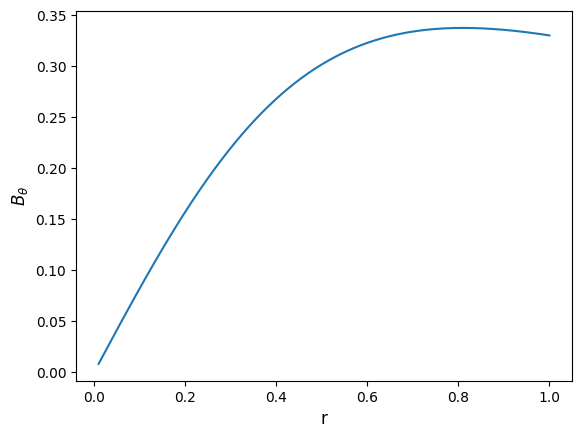

In [8]:
plt.plot(r_mesh, B_theta_profile_num(r_mesh))
plt.xlabel('r', fontsize=12)
plt.ylabel(r'$B_{\theta}$', fontsize=12)

Computation of $dj_{\phi}/dr$

In [9]:
def dj_phi_dr_sym(B_theta_, numerical=False):
    """  Parameters
          - B_theta_ : ratio between the toroidal component and the major radius
          - numerical : if False, return SymPy expr, if True return associated numerical expr
         Returns
          -  : dj_phi_dr_sym, j_phi_sym as SymPy or numerical expr
    """ 
    r, f_ = sym.symbols('r, f')
    max_term = r*B_theta_ # from Maxwell equation
    max_term_sym = sym.sympify(max_term)
    j_phi_sym = sym.diff(max_term_sym, r)/r

    dj_phi_dr_sym = sym.diff(j_phi_sym, r)

    if(numerical==True):
        return sym.lambdify(r, dj_phi_dr_sym), sym.lambdify(r, j_phi_sym) # dj_phi_dr as numerical expression
    else:
        return dj_phi_dr_sym, j_phi_sym # dj_phi_dr as SymPy expression

In [10]:
dj_phi_dr_profile_sym, j_phi_profile_sym = dj_phi_dr_sym(B_theta_profile_sym, numerical=False)
dj_phi_dr_profile_num, j_phi_profile_num = dj_phi_dr_sym(B_theta_profile_sym, numerical=True)

Text(0, 0.5, '$j_{\\phi}$')

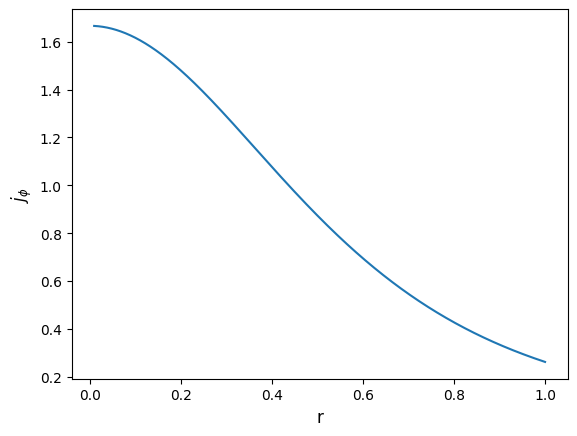

In [11]:
plt.plot(r_mesh, j_phi_profile_num(r_mesh))
plt.xlabel('r', fontsize=12)
plt.ylabel(r'$j_{\phi}$', fontsize=12)

Computation of $c(r) = \left(\frac{m^{2}}{r^{2}}+\frac{dj_{\phi}/dr}{\frac{B_{\theta}}{\mu_{0}}(1-\frac{nq}{m})}\right)$

In [12]:
def c_sym(q_, dj_phi_dr_, B_theta_):
    """ Compute the term in front of y_1 in the expression of y_2  
    Parameters
          - q_ : q profile as SymPy (symbolic) expr
          - dj_phi_dr_ : radial derivative of the current density profile as SymPy expr
    Returns
          -  : factor c as numerical expr
    """
    r, f_ = sym.symbols('r, f')
    c_str = (m**2/r**2)+dj_phi_dr_/((B_theta_)*(1-(n*q_)/m))
    c_ = sym.sympify(c_str)
    
    return sym.lambdify(r, c_) # c(r) as numerical expression

In [13]:
c_num = c_sym(q_profile_sym, dj_phi_dr_profile_sym, B_theta_profile_sym)

In [14]:
def fun(r, y):
    """  Parameters
          r : spatial mesh 
          y : y[0] contains y_1 and y[1] contains y_2  
         Returns
          dxdr : the system of first order ODE contained in sequence vertically
    """
    dxdr = np.vstack((y[1], c_num(r)*y[0]-y[1]/r))
    
    return dxdr

In [15]:
def bc_left(ya, yb): 
    """  Parameters
          x : ya[0] correspond to the value of the solution at the left boundary
          y : yb[0] correspond to the value of the solution at the right boundary  
         Returns
          bc_ : Gives the left boundary conditions
    """
    bc_ = np.array([ya[0], yb[0]-1]) # ensure that the solution is 0 at x=a and 1 at x=b
    return bc_

In [16]:
def bc_right(ya, yb):
    """  Parameters
          x : ya[0] correspond to the value of the solution at the left boundary
          y : yb[0] correspond to the value of the solution at the right boundary  
         Returns
          bc_ : Gives the right boundary conditions
    """
    bc_ = np.array([ya[0]-1, yb[0]]) # ensure that the solution is 1 at x=a and 0 at x=b
    return bc_

In [17]:
def discretization(m_, n_, delta, a=0.01, b=1):
    """ Generate the left/right part of the interval, given the Fourier modes   
    Parameters
          - m_ : number of poloidal Fourier modes
          - n_ : number of toroidal Fourier modes
          - delta : spacing interval between points
          - a : interval initial point
          - b : interval final point
         Returns
          r_array_left, r_array_right, sol : interval on the left/right of the singularity & the r value of the singularity
    """
    def q_discr(r):
        return q_profile_num(r)-m_/n_ # will be used below in root_scalar()
    
    from scipy import optimize
    
    # Computing the r-value for which we have a singularity, i.e solving q(r) - m/n = 0
    comput_sol = optimize.root_scalar(q_discr, bracket=[a, b], method='brentq') 
    sol = comput_sol.root

    # print(sol)
    # Creating the left/right interval w.r.t the singularity 
    eps = 1e-8
    r_left=np.linspace(0.01, sol-eps, 100, endpoint=True)
    r_right=np.linspace(sol+eps, 1, 100, endpoint=True)

    #r_left = np.arange(0.01, sol+delta-eps, delta)
    #r_right = np.arange(sol+eps, 1, delta)

    return r_left, r_right, sol

In [18]:
# Constructing the mesh on the left/right of the singularity
r_array_left_, r_array_right_, sing = discretization(m, n, 1e-7)

In [19]:
# First guess of the solution
#y_left_ = np.zeros((2, r_array_left_.size))
#y_right_ = np.zeros((2, r_array_right_.size))

In [19]:
# Defining the intial guess for the solution
y_left_ = np.random.rand(2, r_array_left_.size)
y_right_ = np.random.rand(2, r_array_right_.size)

# line
y_left_[0] = (1/sing)*r_array_left_
y_left_[1] = y_left_[0]

y_right_[0] = (1/(sing-1))*r_array_right_+(1/(1-sing))*np.ones(r_array_right_.size)
y_right_[1] = y_right_[0]

In [20]:
# Solving for left hand side
sol_left_ = solve_bvp(fun, bc_left, r_array_left_, y_left_, max_nodes=1000)
sol_right_ = solve_bvp(fun, bc_right, r_array_right_, y_right_, max_nodes=1000)

# solution to be plotted
sol_left_plot = sol_left_.sol(r_array_left_)[0]
sol_right_plot = sol_right_.sol(r_array_right_)[0]

In [21]:
# Convergence of the solutation ("success" must be "True")
print(sol_left_)
print('-------------------')
print(sol_right_)

       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 1.000e-02  1.055e-02 ...  6.614e-01  6.614e-01]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x0000023D26FADC60>
             p: None
             y: [[ 3.690e-29  2.901e-04 ...  1.000e+00  1.000e+00]
                 [ 5.425e-01  5.172e-01 ... -6.254e+01 -6.351e+01]]
            yp: [[ 5.425e-01  5.172e-01 ... -6.254e+01 -6.351e+01]
                 [-5.425e+01 -3.861e+01 ... -2.771e+08 -3.629e+08]]
 rms_residuals: [ 1.654e-04  1.627e-04 ...  3.296e-04  6.766e-04]
         niter: 15
-------------------
       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 6.614e-01  6.614e-01 ...  9.966e-01  1.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x0000023D26E3FD80>
             p: None
             y: [[ 1.000e+00  1.000e+00 ...  4.958e-03 -6.752e-31]
        

Text(0, 0.5, '$\\psi$')

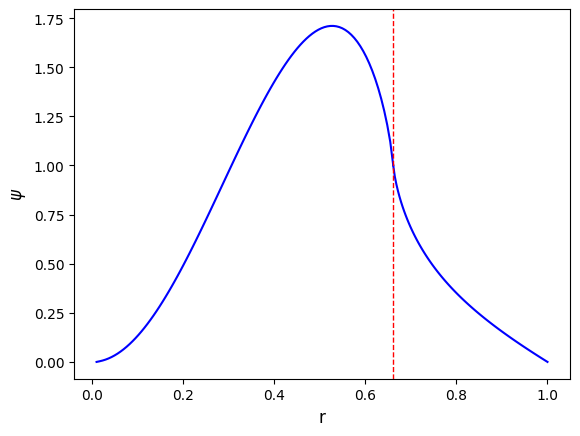

In [24]:
# Plotting the solution
plt.plot(r_array_left_, sol_left_plot, '-b')
plt.plot(r_array_right_, sol_right_plot, '-b')
plt.axvline(x=sing, color='red', linestyle='--', linewidth=1)
plt.xlabel("r", fontsize=12)
plt.ylabel("$\psi$", fontsize=12)

Text(0, 0.5, '$\\psi$')

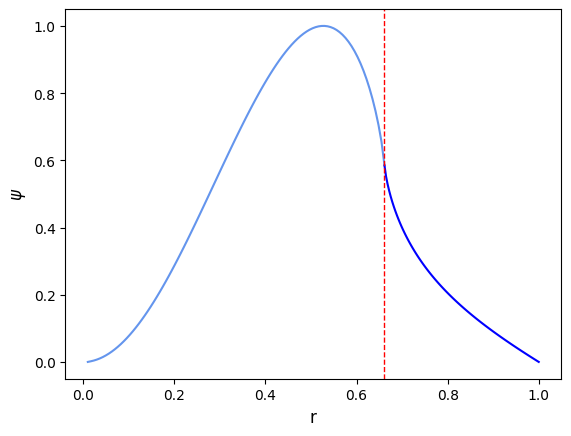

In [27]:
# Plotting the normalized solution
plt.plot(r_array_left_, sol_left_plot/max(sol_left_plot), color='cornflowerblue')
plt.plot(r_array_right_, sol_right_plot/max(sol_left_plot), color='cornflowerblue')
plt.axvline(x=sing, color='red', linestyle='--', linewidth=1)
plt.xlabel("r", fontsize=12)
plt.ylabel("$\psi$", fontsize=12)

Computing $\Delta'$ with the formula, with $r_{s}$ the location of the resonant surface : 

$\Delta' = \lim_{\epsilon \to 0^{+}} \frac{\psi'(r_{s}+\epsilon)-\psi'(r_{s}-\epsilon)}{\psi(r_{s})}$, $\quad$ with $\psi' \equiv \frac{d\psi}{dr}$

In other terms, it's substracting the radial derivative of the perturbation near the resonant surface on the left and on the right, and dividing by the perturbation evaluated on the resonant surface. 

plotting $r_{0}\Delta'$ as a function of $q_{0}$ to observe the stable and unstable regimes. 
- if $\Delta' < 0 \rightarrow$ stable
- if $\Delta' > 0 \rightarrow$ unstable  

$\textbf{NOTE} :$ We plot the quantity $r_{0}\Delta'$ because it's dimensionless.

In [107]:
# Computing delta_prime
delta_prime = (sol_right_.yp[0][0]-sol_left_.yp[0][-1])/sol_right_plot[0]
delta_prime

4.5871267560228475